In [8]:
import copy
import numpy as np
import gpstk
import pandas as pd
from sympy import *
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from numba import autojit
from numpy.linalg import norm
%matplotlib inline
init_printing(use_latex=True)

In [9]:
def TableUDREI(UDREIs):
    inicio = 0.75
    UDRE_mts = []
    UDRE_sigma = []
    T_UDRE = [0.75,1.,1.25,1.75,2.25,3.,3.75,4.5,5.25,6.,7.5,15.,50.,150,0,0]
    T_sigma = [0.0520,0.0924,0.1444,0.2830,0.4678,0.8315,1.2992,1.8709,2.5465,3.3260,5.1968,20.7870,230.9661,2078.695,0,0]
    for i in range (0,len(UDREIs)):
        UDRE_mts.append(T_UDRE[int(UDREIs[i])])
        UDRE_sigma.append(T_sigma[int(UDREIs[i])])
    return UDRE_mts,UDRE_sigma

In [10]:
#functions for calculate position
@autojit
def apply_earth_rotation_to_svs_position(svs, prs):
    c = 299792458
    we = 7.2921159e-5
    rpos = np.zeros(svs.shape)
    pos = np.array(svs)
    for i in range(len(pos)):
        dt = prs[i]/c
        theta = we*dt
        R = np.array([[np.cos(theta), np.sin(theta),0.],[-np.sin(theta), np.cos(theta),0.],[0.,0.,1.]])
        rpos[i] = R.dot(pos[i])
    svs = np.array(rpos)
    return svs
@autojit
def compute_distances(rc, svs):
    # return np.array( [np.sqrt((rc[0]-sv[0])**2 + (rc[1]-sv[1])**2) for sv in svs] )
    return np.linalg.norm(rc-svs, axis=1) #raiz cuadrada de la suma de los cuadrados de los puntos para medir distancia.
@autojit
def predict_pseudoranges(x, prns_pos, prns_clockbias):
    c = 299792458
    rhos    = compute_distances(x[:3], prns_pos)
    pranges = rhos + x[3]-c*prns_clockbias
    #print "rhos: ",rhos
    #print "pranges: ", pranges
    return rhos, pranges
def compute_least_squares_position(svs, svs_clocks, prs, max_iters=200, apply_earth_rotation=True):

    #if apply_earth_rotation:
    svs = apply_earth_rotation_to_svs_position(svs, prs)
    
    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters): #mientras el delta < 1e-8 y no llegue al maximo de iteraciones
        rhos, pranges = predict_pseudoranges(ri, svs, svs_clocks)
        b = prs - pranges
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta
def to_skyplot(elevation, azimut):
    e = np.array(elevation)
    a = np.array(azimut)
    sx = ((90-e)/90) * np.sin (a * (np.pi/180))
    sy = ((90-e)/90) * np.cos (a * (np.pi/180))
    return (sx,sy)
def compute_raim_position(gps_week, gps_sow, prns, prns_pos, pranges,  bcestore):
    if len(prns)==0 or len(prns_pos)==0:
        return np.array([0,0,0])
    t = gpstk.GPSWeekSecond(gps_week, gps_sow).toCommonTime()
    prnList = [gpstk.SatID(int(i[3:])) for i in prns]
    satVector = gpstk.seqToVector(list(prnList), outtype='vector_SatID')
    rangeVector = gpstk.seqToVector([float(i) for i in pranges])
    noTropModel = gpstk.ZeroTropModel()
    raimSolver = gpstk.PRSolution2()
    raimSolver.RAIMCompute(t, satVector, rangeVector, bcestore, noTropModel)   
    r = np.array([raimSolver.Solution[0], raimSolver.Solution[1], raimSolver.Solution[2]])
    return r
def To_WGS84(pos):
    newPosPZ = np.array([pos[0]-0.36,pos[1]+0.08,pos[2]+0.18])
    return newPosPZ

# <font color="purple">SBAS - Space-Based Augmentation System </font>

![img](img/GBASconcept.png)
![img1](img/SBASconcept.png)

The augmentation information provided by SBAS covers <b>corrections and integrity</b> for satellite <b>position</b> errors, satellite <b>clock/time</b> errors and errors induced by the <b>estimation of the delay of the signal while crossing the ionosphere</b>

![img](img/SBAS-GBAS.png)

- Mohinder S Grewal: 
pg 270: lo que se puede arreglar con SBAS, Clock error, Ephemeris, Code and Carrier, Signal distorsion, Bias, Ionosphere, Troposphere. 

![img](http://www.navipedia.net/images/b/b0/SBAS_architecture.png)

- <b>RIMS:</b> Ranging and Integrity Monitoring Station(s) <font color="blue">(34)</font>
- <b>NLES:</b> are the Navigation Land Earth Stations-<font color="blue">(6)</font>
- <b>MCC:</b> is the Mission and Control Center-<font color="blue">(4)</font>
- <b>EWAN:</b> EGNOS Wide-Area (communication) Network (EGNOS)-<font color="blue">(1)</font>

The <b>RIMS</b> tasks are to perform <b>pseudorange measure- ments</b>, demodulate navigation data, mitigate multipath and interference, verify signal integrity, and to packetize and transmit data to the <b>MCC</b> centers.
The <b>MCC</b> then sends all the data to the <b>NLES</b> stations. Every <b>MCC</b> has a backup station that can take over in the event of failure.

<font color="red">The <b>SBAS</b> space segment</font> is composed by several <font color="blue">geostationary satellites</font> in charge of broadcasting, over the service area, the SBAS navigation message. Typically, the SBAS satellites are <font color="blue">multi-purpose</font> (commercial communication) satellites that carry out an additional navigation payload capable to generate a GPS-like signal that retransmits to the users the navigation message generated on-ground.

To enhance the performance of the current <b>GNSS</b> with additional information to:

- <b>Accuracy:</b> Difference between the measured position at any given time to the actual or true position.
- <b>Integrity:</b> Ability of a system to provide timely warnings to users or to shut itself down when it should not be used for navigation. <font color="blue">GPS late 2 hours to notificate to user that to failed a satellite, GLONASS late 16 hours</font>
- <b>Continuity:</b> Ability of a system to perform its function without (unpredicted) interruptions during the intended operation.
- <b>Availability:</b> Ability of a system to perform its function at initiation of intended operation. System availability is the percentage of time that accuracy, integrity and continuity requirements are met.

![img](http://sbas-africa.avantiplc.com/wp-content/uploads/2015/10/sbas-coverage-map-02.png)

![img](img/sbasNames.png)

[Ref](http://mgex.igs.org/IGS_MGEX_Status_SBAS.html)

SBAS Repository
[HERE](http://sis-perfandata.cnes.fr/main_data.html)

In [4]:
#20 March 2015

#Estación en Alemania
navfile = "Rinex_Sbas/IonodphericDay/76/ffmj0760.15n" 
obsfile = "Rinex_Sbas/IonodphericDay/76/ffmj0760.15o" 
glofile = "Rinex_Sbas/IonodphericDay/76/ffmj0760.15g" 

#Estación en República Checa
#navfile = "Rinex_Sbas/IonodphericDay/gope0790.15n" 
#obsfile = "Rinex_Sbas/IonodphericDay/gope0790.15o" 
#glofile = "Rinex_Sbas/IonodphericDay/gope0790.15g" 

#Repository for SBAS => http://sis-perfandata.cnes.fr/main_data.html
sbas_obs = "Rinex_Sbas/IonodphericDay/76/M1200760.15b" #20 March 2015 => EGNOS for European Union

sbas_EGNOS = "Rinex_Sbas/315-h/M1203150.15h" #11 nov 2015 => EGNOS 
sbas_WAAS = "Rinex_Sbas/315-h/M1333150.15h" #11 nov 2015 => WAAS for EEUU


'''type of data:

d = Hatanaka-compressed observation data
f = Beidou navigation message data
g = GLONASS navigation message data 
h = SBAS payload navigation message data
l = GALILEO navigation message data 
m = meteorological data
n = GPS navigation message data
o = observation data
p = mixed GNSS navigation message data
q = QZSS navigation message data
s = observation summary files (extracted from RINEX header)'''
"files"

'files'

### SBAS Navigation File

- <b>SBAS navigation files are similar to Glonass ones</b>, in that both con- tain records of satellite position, velocity and accelerations.

In [5]:
!head -65 $sbas_EGNOS #Navigation File of SBAS

     2.10           H                                       RINEX VERSION / TYPE
ExtractGEONav_1.14  CNES                18-Nov-15 02:42     PGM / RUN BY / DATE
 0.000000000000e+00 0.000000000000e+00      0    0 EGNOS  0 D-UTC A0,A1,T,W,S,U
                                                            END OF HEADER
20 15 11 11  0  0 48.0 0.000000000000E+00 0.000000000000E+00 2.592621000000E+05
    4.063672000000e+04 0.000000000000e+00 0.000000000000e+00 3.100000000000e+01
   -1.124591600000E+04 0.000000000000E+00 0.000000000000E+00-1.000000000000E+00
    0.000000000000E+00 0.000000000000E+00 0.000000000000E+00 2.230000000000E+02
20 15 11 11  0  3 28.0 0.000000000000E+00 0.000000000000E+00 2.594191000000E+05
    4.063672000000e+04 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00
   -1.124591600000E+04 0.000000000000E+00 0.000000000000E+00-1.000000000000E+00
    0.000000000000E+00 0.000000000000E+00 0.000000000000E+00 2.240000000000E+02
20 15 11 11  0  6  8.0 0.000000000000E+00 0.0

![img](img/navHeader.png)

![img](img/navData.png)

In [6]:
!head -65 $sbas_obs

     2.10           B                                       RINEX VERSION / TYPE
ConsolideSBAS       CNES                15/03/24 02:41      PGM / RUN BY / DATE
                    SBAS consolidation file for PRN 120     COMMENT
                                                            END OF HEADER
120 15 03 17 00 00 00.1  L1    32     0   SBA
  4    53 12 80 03 FD 00 14 00 00 00 00 00 00 00 00 00 00 00
       00 00 00 03 B9 7B BB 80 00 00 39 D6 9F 40
120 15 03 17 00 00 01.1  L1    32     0   SBA
  3    9A 0D BF CC 04 80 00 00 7F 90 00 3F BB F8 C0 00 00 00
       00 00 00 03 9B 95 B9 9B BB B9 8D 60 04 80
120 15 03 17 00 00 02.1  L1    32     0   SBA
  2    C6 0A 80 00 00 00 03 FE 80 00 00 00 08 00 00 00 00 00
       03 FF 80 03 BB BB B9 FB BB 9B 96 50 FF C0
120 15 03 17 00 00 03.1  L1    32     0   SBA
 25    53 64 7A 30 7F 99 E8 02 51 2E 0F F3 44 00 24 28 A3 C0
       F2 00 3F 96 85 05 21 3E F7 FD 00 33 7D 00
120 15 03 17 00 00 04.1  L1    32     0   SBA
  4    9A 10 80 03 FD 40 14

one message foe each second

### SBAS Observation File
[HELP](http://www.navipedia.net/index.php/The_EGNOS_SBAS_Message_Format_Explained)

![img](img/obsHeader.png)

![img](img/obsData.png)

#### The Message in Binary is separate like the next table

![img](img/MT.png)

![img](img/SBASmesgFormat.png)

![img](img/RTCA.png)
http://infostore.saiglobal.com/store/details.aspx?ProductID=580789

A brief explanation of the different data fields is presented hereafter:

- <b>Preamble</b>. It is a unique 24–bit field, distributed over three successive words. The preamble sequence (in three consecutive words) is 01010011 (83) (hex 53)- 10011010 (154) (hex 9A)- 11000110 (198) (hex C6). It is assured that the start of the preamble is synchronous with a 6-second GPS sub-frame. Thus, the preamble allows the receiver to achieve frame synchronisation.
- <b>Message Type Identifier</b>. It is a 6-bit field, which permits up to <b>64 different messages</b> (identifiers 0 to 63). Depending on the message type, the information included in the Data field has different meaning. Even though <b>64 type messages are available</b>, only <b>20 are currently defined</b>.
- <b>Data Field</b>. It contains different corrections and integrity information that depends on the type of message. The specific content of this field will be addressed in the following sections.
- <b>Parity Information</b>. The 24 bits of the end of the message (CRC parity bits) provide protection against burst and random error. For more information on parity bits algorithm generator see MOPS
- In Repositories the project [goGPS](https://github.com/goGPS-Project) have the code in matlab for read the SBAS codes.

![img](img/improveSBAS.png)

In [7]:
def Read_SBAS_obs(SBAS_File,Limit):
    FileObs = []
    with open(SBAS_File) as f:
        content = f.readlines()
        i = 0
        Row = 0
        msgHx = ""
        MT = ""
        info = ""
        SATID = []
        Year = []
        Month = []
        Day = []
        Hour = []
        Min = []
        Sec = []
        Band = []
        LDM = []
        FICI = []
        TSI = []
        MTs = []
        Mensaje = []
        for fila in content:
            i+= 1
            if i >= 5: # dont raead the header
                #each 3 rows have information
                Row+= 1
                if Row == 1:
                    info = fila.split()
                if Row == 2:
                    fila = fila.strip('\n')
                    fila = fila.strip('\t')
                    fila = fila.replace(" ","")
                    MT = (fila[0])
                    other = fila[1:]
                    msgHx += other
                if Row == 3:
                    #new = "".join(fila.split("\n"))
                    fila = fila.strip('\n')
                    fila = fila.strip('\t')
                    fila = fila.replace(" ","")
                    msgHx += fila
                    Row = 0
                    #if MT == "2" or MT == "3" or MT == "4" or MT == "5" or MT == "24" or MT == "18" or MT == "26":
                    
                    SATID.append(int(info[0]))
                    Year.append(int(info[1]))
                    Month.append(int(info[2]))
                    Day.append(int(info[3]))
                    Hour.append(int(info[4]))
                    Min.append(int(info[5]))
                    Sec.append(float(info[6]))
                    Band.append(info[7])
                    LDM.append(int(info[8]))
                    FICI.append(int(info[9]))
                    TSI.append(info[10])
                    MTs.append(int(MT))
                    Mensaje.append(msgHx)
                    msgHx = ""
                if i == Limit:
                    break
                RES = pd.DataFrame({"SATID":SATID ,
                                    "Year": Year, 
                                    "Month":Month,
                                    "Day": Day,
                                    "Hour": Hour,
                                    "Min": Min,
                                    "Sec": Sec,
                                    "Band": Band,
                                    "LDM": LDM,
                                    "FICI": FICI,
                                    "TSI": TSI,
                                    "MTs": MTs,
                                    "Mensaje": Mensaje,})
    return RES

In [8]:
DT_SBAS = Read_SBAS_obs(sbas_obs,10000) #Read the File

In [9]:
DT_SBAS.tail()

,Band,Day,FICI,Hour,LDM,MTs,Mensaje,Min,Month,SATID,Sec,TSI,Year
3326,L1,17,0,0,32,2,6C668CBFDFFEF1EF063431613B07603F7FDFFEFFF7FFBC...,55,3,120,26.1,SBA,15
3327,L1,17,0,0,32,3,530EBFEC05C000013FB0003FFFFA00000000000000225F...,55,3,120,27.1,SBA,15
3328,L1,17,0,0,32,2,9A08BFEC000003F58000003F94000003FF000005C003BB...,55,3,120,28.1,SBA,15
3329,L1,17,0,0,32,4,C6118000000038003F40000000000000000000000003BA...,55,3,120,29.1,SBA,15
3330,L1,17,0,0,32,2,553647A387B69DF03512F0C75C3A02414420300FD81939...,55,3,120,30.1,SBA,15


In [10]:
List_MTs = list(DT_SBAS.MTs)
print "Cantidad Datos:", len(List_MTs)

Cantidad Datos: 3331


In [11]:
DT_SBAS.MTs.unique()

array([4, 3, 2, 7, 1, 9], dtype=int64)

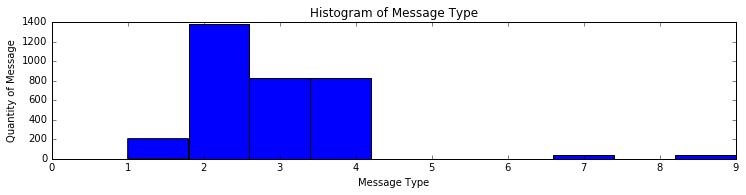

In [12]:
fig =plt.figure(figsize=(10,2))
fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

plt.xlabel('Message Type')
plt.ylabel('Quantity of Message')
plt.title(r'Histogram of Message Type')
plt.hist(List_MTs, bins = 10)
plt.show()

In [4]:
#Example with the frst line of data
#hex1 = "53128038000000003FE00000000000000000" #first line MT 4
#hex2 = "00000003BBBBBB80000023070480"
hex1 = "9A0CBFE4003FF401BFF8000003FFC0000040" #second line MT 3
hex2 = "080000017957BB97957B94FF63C0"
#hex1 = "C66A5015A08B033815C08E047023011C08E0" #third line MT 26
#hex2 = "3801E80FBFDFFEFFF7800CA400C2"
#hex1 = "9A08BFE7FE0000000003FF0000000000003F" #Random line
#hex2 = "EFFCBFEDA7BB97BBB9559B9DFC00"
dec1 = int(hex1+hex2, 16) #hex to int
bina = '{0:04b}'.format(dec1)
msg = copy.copy(bina) #1010101010101.... (256 bits)
print len(hex1+hex2),"hexa, ","Size binary info: ",len(str(bina))
print msg,type(msg)

64 hexa,  Size binary info:  256
1001101000001100101111111110010000000000001111111111010000000001101111111111100000000000000000000000001111111111110000000000000000000000010000000000100000000000000000000000000101111001010101111011101110010111100101010111101110010100111111110110001111000000 <type 'str'>


![img](img/Accuaracy_gps_egnos.png)

In [14]:
def Preamble(BinaryCode):
    return hex(int(BinaryCode[0:8],2))

def MessageType(BinaryCode):
    mt = int(BinaryCode[8:14], 2)
    
    labelmt = ""
    if mt==0:
        labelmt = "Don’t use for safety applications"
    if mt==1:
        labelmt = "PRN mask assignments, set up to 51 of 210 possible"
    if mt >= 2 and mt <= 5:
        labelmt = "Fast corrections"
    if mt==6:
        labelmt = "Integrity information"
    if mt==7:
        labelmt = "Fast correction degradation factor"
    if mt==9:
        labelmt = "Geo Navigation message (X,Y,Z, time, etc.)"
    if mt==10:
        labelmt = "Degradation parameters"
    if mt==12:
        labelmt = "SBAS Network time / UTC offset parameters"
    if mt==17:
        labelmt = "Geo satellite almanacs"
    if mt==18:
        labelmt = "Ionospheric grid points masks"
    if mt==24:
        labelmt = "Mixed fast corrections/long term satellite error corrections"
    if mt==25:
        labelmt = "Long term satellite error corrections"
    if mt==26:
        labelmt = "Ionospheric delay corrections"
    if mt==27:
        labelmt = "SBAS Service message"
    if mt==28:
        labelmt = "Clock Ephemeris Covariance Matrix message"
    if mt==62:
        labelmt = "Internal test message"
    if mt==63:
        labelmt = "Null message"
    return mt,labelmt
    
    
def IODP(BinaryCode):
    label = "OK"
    iodp = int(BinaryCode[224:226],2)
    if iodp == 3:
        label = "Problem with one or more SVs"
    
    return iodp,label

# <font color="red">HEADER - Message Type</font>

In [15]:
print "Preamble: ",Preamble(msg)
print "Message Type: ", MessageType(msg)
print "IODP: ", IODP(msg)

Preamble:  0x9a
Message Type:  (3, 'Fast corrections')
IODP:  (2, 'OK')


<b>Message type 1: </b>
Message type 1 includes the PRN mask assignments, chosen among the applicable GNSS and GEO satellites. Instead of sending for each correction the satellite PRN associated with, a mask is created to save space in the messages. This bit mask contains the i-th bit to 1 to inform that i-th satellite PRN is being used.
Although there are 210 slots (bits) in the mask, only a maximum of 51 can be set at a time due to constraint in the limited size available to broadcast information (message type 6 does only have enough free space to allocate UDREI figures for 51 satellites). Corrections are provided only for these satellites.
The user will read the mask and then each satellite correction will be related with the satellite via the mask contained in this message. IODP indicates the mask’s applicability to the corrections contained in the messages to which the mask applies. [PRN Slot list](https://github.com/mvglasow/satstat/wiki/NMEA-IDs)


In [16]:
'''%EGNOS MT1 message structure (PRN mask):
% 8 bit: preamble
% 6 bit: message type (MT)
% 32 bit: bit mask for GPS satellites, ordered from PRN 1 to 32
%   se bit = 0 -> SV to be disregarded
%   se bit = 1 -> SV to be used
%       es: 01111111111111111111111111111110
%       PRN 1  NOT available (bit 1 = 0)
%       PRN 2  available     (bit 2 = 1)
%       ...
%       PRN 31 available     (bit 31 = 1)
%       PRN 32 NOT available (bit 32 = 0)
% 180 bit: bit mask for other satellites (eg: GLONASS)
% 24 bit: parity
% TOTAL: 250 bit'''
"EGNOS MT1 (PRN mask)"

'EGNOS MT1 (PRN mask)'

In [17]:
'''NMEA IDs can be roughly divided into the following ranges:

1–32: GPS
33–54: Various SBAS systems (EGNOS, WAAS, SDCM, GAGAN, MSAS) – some IDs still unused
55–64: not used (might be assigned to further SBAS systems)
65–88: GLONASS
89–96: GLONASS (future extensions?)
97–192: not used
193–195: QZSS
196–200: QZSS (future extensions?)
201–235: Beidou'''
"NMEA IDs"

'NMEA IDs'

Elkin David Diaz....

In [18]:
def PRNAvalible(BinaryCode): #this is part of MT=1
    BinaryList = BinaryCode[14:14+235]
    label = "not-assigned"
    if PRN_NMEA == 1:
        res = BinaryList[0]
    else:
        res = BinaryList[PRN_NMEA-1:PRN_NMEA]
        
    if(PRN_NMEA>=1 and PRN_NMEA<=32):
        label = "GPS"
    if(PRN_NMEA>=65 and PRN_NMEA<=88):
        label = "GLONASS"
    if(PRN_NMEA>=196 and PRN_NMEA<=200):
        label = "QZSS"
    if(PRN_NMEA>=201 and PRN_NMEA<=235):
        label = "Beidou"
    return bool(res),label

## Message types 2 to 5:
Approximately the <b>$75 $%</b> of the data that sends the GEO contains only Fast Corrections data.

- <b>Pseudo Range Corrections (PRC):</b> to be added on the pseudorange of each satellite
- <b>User Differential Range Correction Indicators (UDREI):</b> are satellite health parameters which take values between 1 (very healthy) and 15 (do not use). Each value is equivalent to a certain weight to be applied on the weighting matrix (explained in detail in section 2.3. The SBAS Basic Positioning Equation). If it is equal to 14 it means that the satellite is not monitored and if it is equal to <b>15</b> it means that the satellite may be experiencing <b>technical problems</b> and its ranging data must not be used.
<b>differential corrections range: -256.000 a +255.875 [meters]</b>


The time of applicability of the fast corrections, which is used in fast correction computation, is defined as the start of the epoch of the SBAS Network Time (SNT) second that is coincident with the transmission of the first bit of the message block (bit belonging to the preamble) at the GEO satellite.
The message format is defined the section A.4.4.3 of MOPS, as well as the table that the SBAS user will consider to translate the $UDREI$ to a variance $σ^2UDRE$. Note that the status of the satellite is also included into the UDREI:
- <b>Use:</b> UDREIs from 0 to 13 indicates that the satellite is usable.
- <b>Not Monitored:</b> UDREI=14 indicates that the satellite does not appear in the mask or even appearing there are not corrections or UDRE values available for it.
- <b>Don’t Use:</b> UDREI=15 indicates that an inconsistency has been found for this satellite (alarm situation) or the estimated fast correction is greater than 256.0 m.

![img](img/MT2.png)

In [19]:
#This function is just is MT = 2,3,4,0
def MT2_FastCorrections(BinaryCode):
    #iodp,_ = IODP(BinaryCode)
    #compute the PRC - PSEUDORANGE correction
    #start bit and end bit of the 13 PRCs in MT 2, 3, 4
    start_bit = np.linspace(19,163,13)
    end_bit   = np.linspace(30,174,13)
    #allocate the 13 binary numbers that correspond to the PRCs
    PRCs = []
    PRCs_b = []
    print "--------------Pseudorange Range Correction--------------"
    for j in range(0,13):
        print int(start_bit[j])," To ",int(end_bit[j])
        num_bin = msg[int(start_bit[j]-1):int(end_bit[j])]
        
        num_int = int(num_bin,2)
        res = 0.125 # LSB value = 0.125 (m)
        param_11 = 2047 #2^(n_bit-1) - 1
        #convert in twos complement
        p11 = num_int > param_11
        num_int = num_int - 4096 * int(p11)#4096 is 2^(11)
        PRC = num_int * res # meters
        
        PRCs.append(num_bin)
        PRCs_b.append(PRC)
        print "[",num_bin,"]", " PRC =>",PRC
        
    #start bit and end bit of the 13 UDREIs in MT 2, 3, 4
    start_bit_u = np.linspace(175,223,13)#[175 : 4 : 223];
    end_bit_u   = np.linspace(178,226,13)#[178 : 4 : 226];
    UDREIs = []
    UDREIs_b = []
    print "--------------UDREI--------------" #User Differential Range Error (meters)
    for j in range(0,13):
        print int(start_bit_u[j])," To ",int(end_bit_u[j])
        num_bin = msg[int(start_bit_u[j]-1):int(end_bit_u[j])]
        UDREIs.append(num_bin)
        UDREIs_b.append(int(num_bin,2))
        print "[",num_bin,"]", " to Int =>",int(num_bin,2)
    #WHAT SATELLITES?
    SV = []
    MT,_ = MessageType(msg)
    if MT == 2 or MT == 0:
        SV = range(1,14) #1 to 13
    elif MT == 3:
        SV = range(14,27) #14 to 26
    elif MT == 4:
        SV = range(27,40) #27 to 39
    elif MT == 5:
        SV = range(41,54) #41 to 53
    #SATELITES, UDREIs, 
    return SV,UDREIs_b,PRCs_b

In [20]:
#This function is just is MT = 24
def MT24_FastCorrections(BinaryCode):
    iodp,_ = IODP(BinaryCode)
    
    start_bit = np.linspace(15,75,6)
    end_bit   = np.linspace(26,86,6)
    #15   27   39   51   63   75
    #26   38   50   62   74   86
    
    PRCs = []
    for j in range(0,6):
        print int(start_bit[j])," To ",int(end_bit[j])
        num_bin = msg[int(start_bit[j]-1):int(end_bit[j])]
        
        num_int = int(num_bin,2)
        res = 0.125 # LSB value = 0.125 (m)
        param_11 = 2047 #2^(n_bit-1) - 1
        #convert in twos complement
        p11 = num_int > param_11
        num_int = num_int - 4096 * int(p11)#4096 is 2^(11)
        PRC = num_int * res # meters
        
        PRCs.append(PRC)
        print "[",num_bin,"]", " PRC =>",PRC
        
    start_bit_u = np.linspace(87,107,6)
    end_bit_u   = np.linspace(90,110,6)
    UDREIs = []
    for j in range(0,6):
        print int(start_bit_u[j])," To ",int(end_bit_u[j])
        num_bin = msg[int(start_bit_u[j]-1):int(end_bit_u[j])]
        UDREIs.append(num_bin)
        print "[",num_bin,"]", " to Int =>",int(num_bin,2)
    SV_block = [range(1,7),range(14,20),range(27,33)]
    iodp = int(BinaryCode[111:112],2)
    block_ID = int(BinaryCode[113:114],2) 
    SV = SV_block[block_ID+1]
    iodf = int(BinaryCode[115:116],2) 
    #NOTE:
    # IODF = 0,1,2: OK
    #      = 3:     problem with one or more SVs
    return SV,UDREIs,PRCs,iodp

In [21]:
sv,udreis,prcs = MT2_FastCorrections(msg) #Because MT for this e.g. is 3
mts,sigma = TableUDREI(udreis)
Results = pd.DataFrame({"Sat":sv ,"UDRE": udreis, "UDRE_Mts":mts, "UDRE_variance":sigma,"PRC [mts]":prcs})
Results

--------------Pseudorange Range Correction--------------
19  To  30
[ 111111111001 ]  PRC => -0.875
31  To  42
[ 000000000000 ]  PRC => 0.0
43  To  54
[ 111111111101 ]  PRC => -0.375
55  To  66
[ 000000000110 ]  PRC => 0.75
67  To  78
[ 111111111110 ]  PRC => -0.25
79  To  90
[ 000000000000 ]  PRC => 0.0
91  To  102
[ 000000000000 ]  PRC => 0.0
103  To  114
[ 111111111111 ]  PRC => -0.125
115  To  126
[ 000000000000 ]  PRC => 0.0
127  To  138
[ 000000000001 ]  PRC => 0.125
139  To  150
[ 000000000010 ]  PRC => 0.25
151  To  162
[ 000000000000 ]  PRC => 0.0
163  To  174
[ 000000000000 ]  PRC => 0.0
--------------UDREI--------------
175  To  178
[ 0101 ]  to Int => 5
179  To  182
[ 1110 ]  to Int => 14
183  To  186
[ 0101 ]  to Int => 5
187  To  190
[ 0101 ]  to Int => 5
191  To  194
[ 1110 ]  to Int => 14
195  To  198
[ 1110 ]  to Int => 14
199  To  202
[ 1110 ]  to Int => 14
203  To  206
[ 0101 ]  to Int => 5
207  To  210
[ 1110 ]  to Int => 14
211  To  214
[ 0101 ]  to Int => 5
215  T

,PRC [mts],Sat,UDRE,UDRE_Mts,UDRE_variance
0,-0.875,14,5,3,0.8315
1,0.000,15,14,0,0.0000
2,-0.375,16,5,3,0.8315
3,0.750,17,5,3,0.8315
4,-0.250,18,14,0,0.0000
5,0.000,19,14,0,0.0000
6,0.000,20,14,0,0.0000
7,-0.125,21,5,3,0.8315
8,0.000,22,14,0,0.0000
9,0.125,23,5,3,0.8315


<b>UDRE</b> User Differential Range Error (meters) - estimates the uncertainty of the correction

![img](img/UDREI.png)

### Comparing with SBAS TEACHER by [eesa](http://www.egnos-pro.esa.int/sbasteacher/)

![img](img/decode2A.JPG)

![img](img/decode2B.JPG)

# IONOSPHERIC EXAMPLE

In [5]:
def HexaToBitMessage(msgHexa):
    dec1 = int(msgHexa, 16) #hex to int
    bina = '{0:04b}'.format(dec1)
    msg = copy.copy(bina) #1010101010101.... (256 bits)
    return msg

## Message Type 18

In [ ]:
'''
% INPUT:
%   msg = hexadecimal string for 1 EGNOS message (from .ems files)
%         eg: msg = ('534964000000FFFFFFC00000001FFFC00001FFFC00003FFFE001FC003C15ABC0');
%
% OUTPUT:
%   n_bands = number of transmitted bands
%   band = band number
%   iodi = band IODI
%   igp_mask = IGP mask
%
% DESCRIPTION:
%   The IGP mask (MT 18) connects the ionospheric delay for each node
%   of the MT 26 to the right IGP (Iono Grid Point).'''

In [53]:
msg = ('534964000000FFFFFFC00000001FFFC00001FFFC00003FFFE001FC003C15ABC0')
BinMsg = HexaToBitMessage(msg)

In [79]:
n_band = int(BinMsg[13:17], 2)# must be between (0-11)
band = int(BinMsg[17:21], 2) # must be between (0-10)
iodi = int(BinMsg[21:23], 2) # must be between (0-3)
mask = BinMsg[23:201+23]
igp = range(1,202)
igp_mask = []
for i in range (0,201):
    if mask[i]=='1':
        igp_mask.append(igp[i])
    else:
        igp_mask.append(0)

print n_band,band,iodi,len(mask),len(igp)

5 9 0 201 201


In [80]:
igp_mask,len(igp_mask)

#### Load the Iono Grid Point (IGP) masks referring to each band (MT 18).

![img](img/MT18.png)

## MessageType 26

In [6]:
messageInospheric = "536A53FDFFEF05C02DC16E0A7053829C14FFEFFF7FFBFFDFFEFFF7803BEF9280"
#MEssage Type =  26

In [47]:
#band  = output band
#block = output block
#ivd   = ionospheric vertical delays
#givei = output givei
#igp   = output IGP
print "output band", band
print "output block", block
print "ionospheric vertical delays", ivd
print "output givei",givei

output band 9
output block 4
ionospheric vertical delays [ 63.75   63.75    1.375   1.375   1.375   1.25    1.25    1.25    1.25
  63.75   63.75   63.75   63.75   63.75   63.75 ]
output givei [15, 15, 8, 7, 7, 7, 7, 7, 7, 15, 15, 15, 15, 15, 15]


In [34]:
MessagesGridBin = []
MessagesGridDec = []
#band  = output band
#block = output block
#ivd   = ionospheric vertical delays
#givei = output givei
#igp   = output IGP

risoluzione = 0.125 #mts
BinMsg = HexaToBitMessage(messageInospheric)
band = int(BinMsg[13:17], 2)#cmust be 9 - fbin2dec(s(15:18));
block = int(BinMsg[17:21], 2) # must be 4 - fbin2dec(s(19:22));
start_bit = np.linspace(23,205,15)#  [23 : 13 : 205];
end_bit   = np.linspace(31,213,15)#  [31 : 13 : 213];

for j in range(0,15):
    print int(start_bit[j])," To ",int(end_bit[j])
    BinSep =  BinMsg[int(start_bit[j]-2):int(end_bit[j]-1)]
    DecSep = int(BinSep,2)
    print BinSep," -> ",DecSep
    MessagesGridBin.append(BinSep)
    MessagesGridDec.append(DecSep)
ivd = np.array(MessagesGridDec) * risoluzione

23  To  31
111111110  ->  510
36  To  44
111111110  ->  510
49  To  57
000001011  ->  11
62  To  70
000001011  ->  11
75  To  83
000001011  ->  11
88  To  96
000001010  ->  10
101  To  109
000001010  ->  10
114  To  122
000001010  ->  10
127  To  135
000001010  ->  10
140  To  148
111111110  ->  510
153  To  161
111111110  ->  510
166  To  174
111111110  ->  510
179  To  187
111111110  ->  510
192  To  200
111111110  ->  510
205  To  213
111111110  ->  510


In [43]:
givei = []
start_bit = np.linspace(32,214,15)#  [23 : 13 : 205]; [32 : 13 : 214];
end_bit   = np.linspace(35,217,15)#  [31 : 13 : 213]; [35 : 13 : 217];

for j in range(0,15):
    print int(start_bit[j])," To ",int(end_bit[j])
    BinSep =  BinMsg[int(start_bit[j]-2):int(end_bit[j]-1)]
    DecSep = int(BinSep,2)
    print BinSep," -> ",DecSep
    givei.append(DecSep)


32  To  35
1111  ->  15
45  To  48
1111  ->  15
58  To  61
1000  ->  8
71  To  74
0111  ->  7
84  To  87
0111  ->  7
97  To  100
0111  ->  7
110  To  113
0111  ->  7
123  To  126
0111  ->  7
136  To  139
0111  ->  7
149  To  152
1111  ->  15
162  To  165
1111  ->  15
175  To  178
1111  ->  15
188  To  191
1111  ->  15
201  To  204
1111  ->  15
214  To  217
1111  ->  15


![img](img/MT26.png)

![img](img/IPP.png)